In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.metrics import r2_score, accuracy_score, roc_curve
from sklearn.model_selection import LeaveOneOut
from numpy.linalg import pinv
import gc
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=np.inf)
plt.rc('animation', html='html5')
plt.rcParams["figure.figsize"] = 6, 6

def printmd(string):
    display(Markdown(string))

In [273]:
def read(file):
    df = pd.read_csv(file)

    train = df.sample(frac=0.9)
    test  = df.drop(train.index)

    split = lambda df: (
        df.drop('label', axis=1).as_matrix(),
        df.label.as_matrix())
    global trainX, trainY, testX, testY
    trainX, trainY = split(train)
    testX, testY   = split(test)

Регрессия. Во всех задачах нужно будет визуализировать получившуюся функцию на датасете `noisysine.csv` и посчитать `R-score` для датасета `hydrodynamics.csv`.

### task 1

Реализуйте алгоритм линейной регрессии, и полиномиальной регрессии (для датасета `noisysine` — степеней от 2 до 5, для датасета `hydrodynamics` — степени 2) без регуляризации.

$$\quad \mathbf {y} ={\begin{pmatrix}y_{1}\\y_{2}\\\vdots \\y_{n}\end{pmatrix}}, \qquad {\displaystyle X={\begin{pmatrix}\mathbf {x} _{1}^{\top }\\\mathbf {x} _{2}^{\top }\\\vdots \\\mathbf {x} _{n}^{\top }\end{pmatrix}}={\begin{pmatrix}1&x_{11}&\cdots &x_{1p}\\1&x_{21}&\cdots &x_{2p}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{np}\end{pmatrix}},} \qquad {\displaystyle {\boldsymbol {\beta }}={\begin{pmatrix}\beta _{0}\\\beta _{1}\\\beta _{2}\\\vdots \\\beta _{p}\end{pmatrix}},\qquad {\boldsymbol {\varepsilon }}={\begin{pmatrix}\varepsilon _{1}\\\varepsilon _{2}\\\vdots \\\varepsilon _{n}\end{pmatrix}}.} $$

<div align="center">fit:</div>
$$ {\displaystyle {\hat {\boldsymbol {\beta }}}=(\mathbf {X} ^{\top }\mathbf {X} )^{-1}\mathbf {X} ^{\top }\mathbf {y} =\left(\sum \mathbf {x} _{i}\mathbf {x} _{i}^{\top }\right)^{-1}\left(\sum \mathbf {x} _{i}y_{i}\right).} $$

<div align="center">predict:</div>
$$ {\displaystyle \mathbf {y} =X{\boldsymbol {\beta }}+{\boldsymbol {\varepsilon }},\,} $$


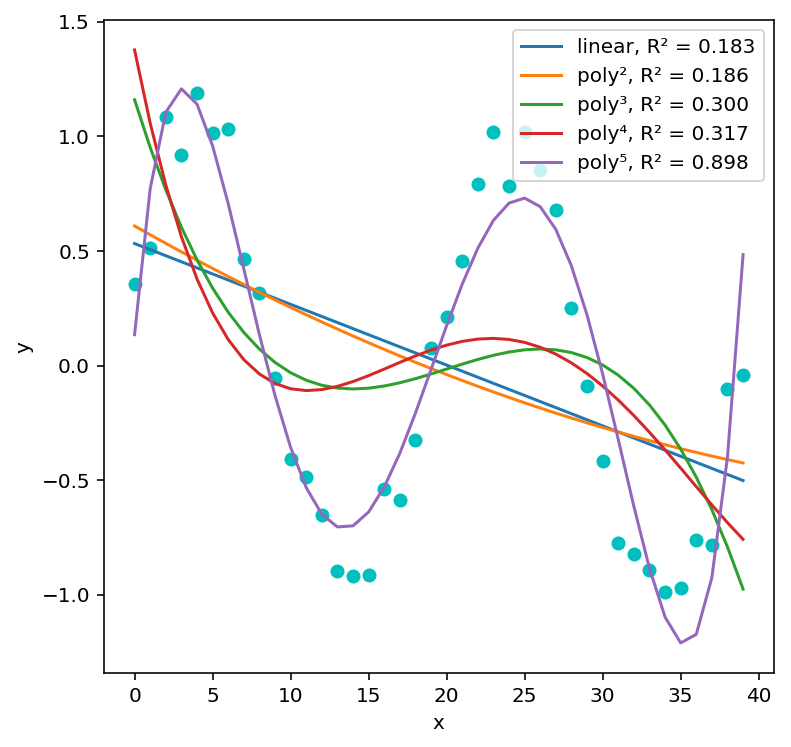

In [268]:
df = pd.read_csv('noisysine.csv')
df.plot('x', 'y', kind='scatter')

x = df.x.values
y = np.vstack(df.y.values)
plt.plot(x, y, 'co')

xacc = np.ones((len(x), 1))

for i in range(1, 6):
    xacc = np.c_[xacc, np.vstack(x) * np.vstack(xacc.T[-1])]

    X    = np.matrix(xacc)
    b    = (X.T * X).I * X.T * y

    text = 'linear' if i == 1 else f'poly{["²", "³", "⁴", "⁵"][i - 2]}'
    plt.plot(x, X * b, label=f'{text}, R² = {r2_score(y, X * b):.3f}')

plt.legend(); plt.show()

In [269]:
df = pd.read_csv('hydrodynamics.csv')
x  = df.drop('y', axis=1).as_matrix()
y  = np.vstack(df.y.values)


# linear regression
xacc = np.ones((len(x), 1))
xacc = np.c_[xacc, x * np.vstack(xacc.T[-1])]

X = np.matrix(xacc)
b = pinv(X.T * X) * (X.T) * y
print(f'linear, R² = {r2_score(y, X * b):.3f}')


# add col[i] * col[j] features
for i in range(x.shape[1]):
    for j in range(x.shape[1]):
        xacc = np.c_[xacc, np.vstack(x.T[i]) * np.vstack(x.T[j])]

X = np.matrix(xacc)
b = pinv(X.T * X) * (X.T) * y
print(f'poly²,  R² = {r2_score(y, X * b):.3f}')


linear, R² = 0.658
poly²,  R² = 0.930


### task 2

Реализуйте алгоритм гребневой регрессии и найдите оптимальный параметр регуляризации для случаев из задачи 1.

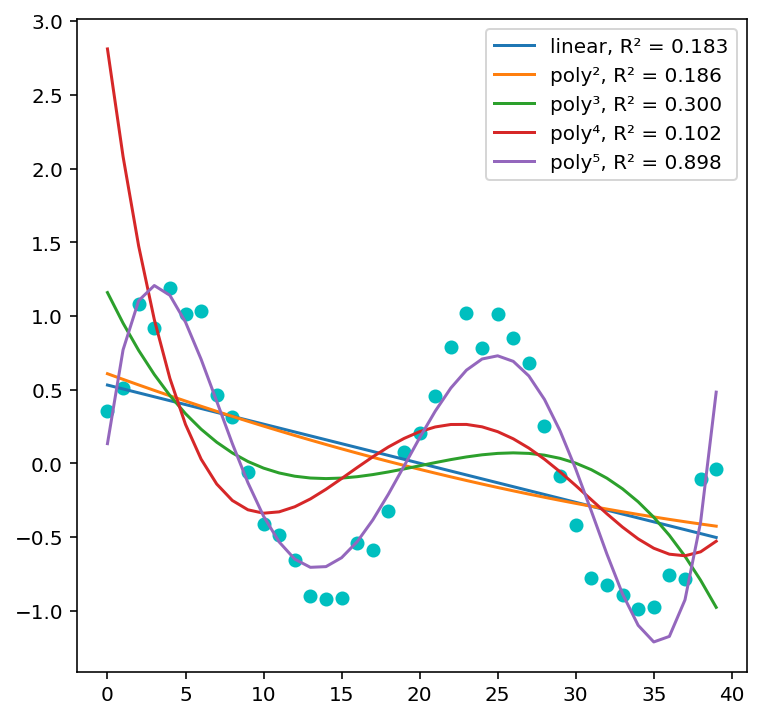

In [4]:
df = pd.read_csv('noisysine.csv')
x  = df.x.values
xM = np.vstack(x)
y  = np.vstack(df.y.values)
plt.plot(x, y, 'co')

loo  = LeaveOneOut()
xacc = np.ones((len(x), 1))

for i in range(1, 6):
    xacc = np.c_[xacc, xM * np.vstack(xacc.T[-1])]
    X    = np.matrix(xacc)

    best_alpha, best_score = -1, 0

    for alpha in np.linspace(2**(-15), 2**15, 300):
        res = np.zeros(y.shape[0])

        for trainIdx, testIdx in loo.split(X):
            XX, YY = X[trainIdx], y[trainIdx]
            b      = (XX.T * XX + (alpha) * np.identity(XX.shape[1])).I * XX.T * YY
            res[testIdx] = X[testIdx] * b

        score = r2_score(y, res)
        if score > best_score:
            best_alpha, best_score = alpha, score

    
    b = (X.T * X + (best_alpha) * np.identity(X.shape[1])).I * X.T * y
    text = 'linear' if i == 1 else f'poly{["²", "³", "⁴", "⁵"][i - 2]}'
    plt.plot(x, X * b, label=f'{text}, R² = {r2_score(y, X * b):.3f}')

plt.legend(); plt.show()

In [7]:
df = pd.read_csv('hydrodynamics.csv')
x  = df.drop('y', axis=1).as_matrix()
y  = np.vstack(df.y.values)


# linear regression
xacc = np.ones((len(x), 1))
xacc = np.c_[xacc, x * np.vstack(xacc.T[-1])]
X    = np.matrix(xacc)
loo  = LeaveOneOut()


best_alpha, best_score = -1, 0

for alpha in np.linspace(2**(-15), 2**15, 300):
    res = np.zeros(y.shape[0])
    
    for trainIdx, testIdx in loo.split(X):
        XX, YY = X[trainIdx], y[trainIdx]
        b      = pinv(XX.T * XX + (alpha) * np.identity(XX.shape[1])) * XX.T * YY
        res[testIdx] = X[testIdx] * b

    score = r2_score(y, res)
    if score > best_score:
        best_alpha, best_score = alpha, score

b = pinv(X.T * X + (best_alpha) * np.identity(X.shape[1])) * X.T * y
print(f'linear, R² = {r2_score(y, X * b):.3f}')



# add col[i] * col[j] features
for i in range(x.shape[1]):
    for j in range(x.shape[1]):
        xacc = np.c_[xacc, np.vstack(x.T[i]) * np.vstack(x.T[j])]

X   = np.matrix(xacc)
loo = LeaveOneOut()

best_alpha, best_score = -1, 0

for alpha in np.linspace(2**(-15), 2**15, 300):
    res = np.zeros(y.shape[0])
    
    for trainIdx, testIdx in loo.split(X):
        XX, YY = X[trainIdx], y[trainIdx]
        b      = pinv(XX.T * XX + (alpha) * np.identity(XX.shape[1])) * XX.T * YY
        res[testIdx] = X[testIdx] * b

    score = r2_score(y, res)
    if score > best_score:
        best_alpha, best_score = alpha, score

b = pinv(X.T * X + (best_alpha) * np.identity(X.shape[1])) * X.T * y
print(f'poly²,  R² = {r2_score(y, X * b):.3f}')


linear, R² = 0.658
poly²,  R² = 0.930


### task 3

Используйте алгоритмы (например, из библиотеки sklearn) LASSO и Elastic Net регрессии и оптимизируйте параметры регуляризации для случаев из задачи 1. Сколько признаков используется в лучшей конфигурации?

##### lasso

[ 0.        -0.0265171]
[ 0.         -0.0386472   0.00031103]
[ 0.00000000e+00 -2.02796413e-01  1.10298335e-02 -1.83890727e-04]
[ 0.00000000e+00 -1.81466639e-01  8.56424416e-03 -8.74768715e-05
 -1.20546140e-06]
[ 0.00000000e+00 -1.99021698e-01  1.09797454e-02 -1.34059718e-04
 -3.58252901e-06  6.02886357e-08]


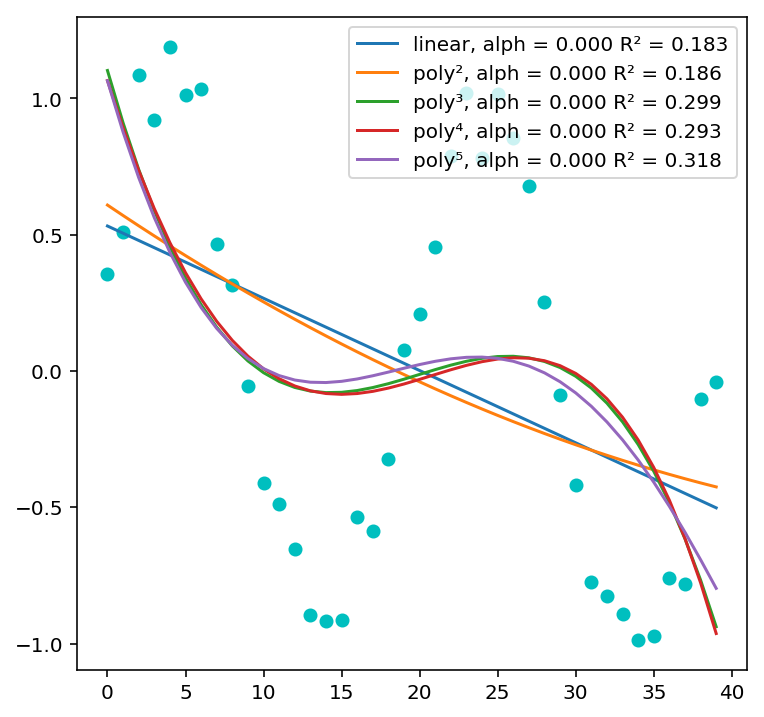

In [15]:
from sklearn.linear_model import Lasso
import warnings

df = pd.read_csv('noisysine.csv')
x  = df.x.values
xM = np.vstack(x)
y  = np.vstack(df.y.values)
plt.plot(x, y, 'co')

loo  = LeaveOneOut()
xacc = np.ones((len(x), 1))

for i in range(1, 6):
    xacc = np.c_[xacc, xM * np.vstack(xacc.T[-1])]
    X    = np.matrix(xacc)

    alphas = np.linspace(2**(-30), 2**15, 300)
    scores = []

    for alpha in alphas:
        res = np.zeros(y.shape[0])
        las = Lasso(alpha)

        for trainIdx, testIdx in loo.split(X):
            XX, YY = X[trainIdx], y[trainIdx]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res[testIdx] = las.fit(XX, YY).predict(X[testIdx])  # lasso

        scores.append(r2_score(y, res))
    
    idx = np.argmax(scores)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = Lasso(alphas[idx]).fit(X, y)
        print(res.coef_)
        res = res.predict(X)
    text = 'linear' if i == 1 else f'poly{["²", "³", "⁴", "⁵"][i - 2]}'
    plt.plot(x, res, label=f'{text}, alph = {alphas[idx]:.3f} R² = {r2_score(y, res):.3f}')
    
plt.legend(); plt.show()

В лучшей конфигурации (poly⁵) используется 5 признаков.

##### elastic net

[ 0.         -0.02651691]
[ 0.00000000e+00 -2.73858410e-05 -5.53637391e-04]
[ 0.00000000e+00 -2.02154066e-01  1.09926238e-02 -1.83299578e-04]
[ 0.00000000e+00 -1.80897270e-01  8.52553542e-03 -8.65551725e-05
 -1.21218106e-06]
[ 0.00000000e+00 -1.98920144e-01  1.09727674e-02 -1.33913148e-04
 -3.58228007e-06  6.02637308e-08]


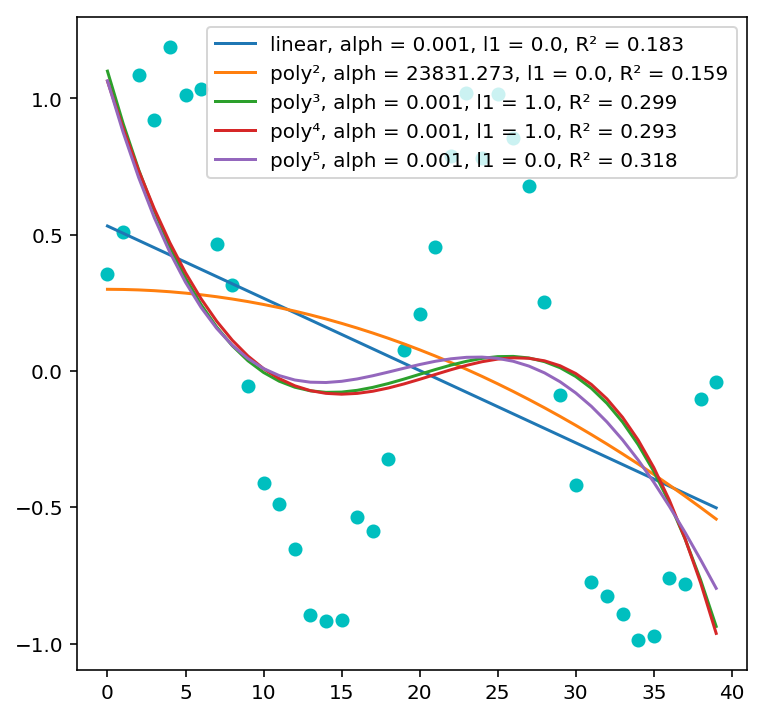

In [17]:
from sklearn.linear_model import ElasticNet as elas  # just rename
import warnings

df = pd.read_csv('noisysine.csv')
x  = df.x.values
xM = np.vstack(x)
y  = np.vstack(df.y.values)
plt.plot(x, y, 'co')

loo  = LeaveOneOut()
xacc = np.ones((len(x), 1))

for i in range(1, 6):
    xacc = np.c_[xacc, xM * np.vstack(xacc.T[-1])]
    X    = np.matrix(xacc)

    
    best_alpha, best_l1, best_score = -1, -1, 0

    for l1_ratio in np.linspace(0, 1, 50):
        for alpha in np.linspace(2**(-10), 2**15, 100):
            res = np.zeros(y.shape[0])
            las = elas(alpha, l1_ratio=l1_ratio)  # add l1_ratio

            for trainIdx, testIdx in loo.split(X):
                XX, YY = X[trainIdx], y[trainIdx]
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    res[testIdx] = las.fit(XX, YY).predict(X[testIdx])  # elasic

            score = r2_score(y, res)
            if score > best_score:
                best_alpha, best_l1, best_score = alpha, l1_ratio, score
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = elas(best_alpha, l1_ratio=best_l1).fit(X, y)
        print(res.coef_)
        res = res.predict(X)
    text = 'linear' if i == 1 else f'poly{["²", "³", "⁴", "⁵"][i - 2]}'
    plt.plot(x, res, label=f'{text}, alph = {best_alpha:.3f}, l1 = {best_l1}, R² = {r2_score(y, res):.3f}')
    
plt.legend(); plt.show()

В лучшей конфигурации (poly⁵) используется 5 признаков.